# Setup & Imports

In [31]:

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import preModelling.data_config as config
from modelling.GeoClusterer import GeoClusterer
from modelling.feature_config import NUM_ALL, CAT_ALL, BOOL_ALL
from modelling.feature_importance import plot_lin_feature_importance, \
  plot_tree_feature_importance
from modelling.modelling_config import (
  N_PICKUP_CLUSTERS, N_DROPOFF_CLUSTERS, RANDOM_SEED, KMEANS_BATCH_SIZE
)
from modelling.modelling_utils import make_all_models, feature_to_category, \
  feature_as_bool
from modelling.transformer import build_haversine_transformer, \
  make_linear_pipeline
from modelling.transformer import get_display_models_results, \
  compare_models_results
from modelling.transformer import (
  num_base_pipelining,
  cat_base_pipelining,
  bool_base_pipelining
)

In [7]:
# Load taxi and weather data
taxi_weather_df = pd.read_csv(config.TAXI_WEATHER_DATA_SAVE)

for dt in ["pickup_datetime", "dropoff_datetime"]:
  taxi_weather_df[dt] = pd.to_datetime(taxi_weather_df[dt])

taxi_weather_df = feature_to_category(taxi_weather_df, CAT_ALL)
taxi_weather_df = feature_as_bool(taxi_weather_df, BOOL_ALL)

taxi_weather_df = taxi_weather_df.drop(columns=["id", 'dropoff_datetime', "pickup_datetime"
                                                ], errors="ignore")

# Train/Test Split

In [8]:
# everything until 31-05-2016 as a Training Base
TARGET_COL = 'trip_duration_log'

train_df, test_df = train_test_split(taxi_weather_df, test_size=0.2, random_state=42)

X_train, y_train = train_df.drop(columns=[TARGET_COL]), train_df[TARGET_COL]

X_holdout, y_holdout = test_df.drop(columns=[TARGET_COL]), test_df[TARGET_COL]

# Preprocessing-Configuration

In [9]:
num_pipe = num_base_pipelining()
cat_pipe = cat_base_pipelining()
bool_pipe = bool_base_pipelining()

geo_pick = GeoClusterer(
    cols=['pickup_longitude', 'pickup_latitude'],
    n_clusters=N_PICKUP_CLUSTERS,
    random_state=RANDOM_SEED,
    batch_size=KMEANS_BATCH_SIZE
)
geo_drop = GeoClusterer(
    cols=['dropoff_longitude', 'dropoff_latitude'],
    n_clusters=N_DROPOFF_CLUSTERS,
    random_state=RANDOM_SEED,
    batch_size=KMEANS_BATCH_SIZE
)
hav_trans = build_haversine_transformer()

preprocessing = ColumnTransformer(
    transformers=[
      ('num', num_pipe, NUM_ALL),
      ('cat', cat_pipe, CAT_ALL),
      ('bool', bool_pipe, BOOL_ALL),
      ('g_pick', geo_pick, ['pickup_longitude', 'pickup_latitude']),
      ('g_drop', geo_drop, ['dropoff_longitude', 'dropoff_latitude']),
      ('hav', hav_trans,
       ['pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude']),
    ],
    remainder="drop",
)

# Hyperparameter search

In [33]:
param_dist_xgb = {
  'model__n_estimators': [200, 400, 800],
  'model__max_depth': [6, 10],
  'model__learning_rate': [0.03, 0.1],
  'model__subsample': [0.8, 1.0],
  'model__colsample_bytree': [0.7, 0.9],
  'model__gamma': [0, 1],
}
param_dist_lgbm = {
  'model__n_estimators': [400, 700, 1000],
  'model__learning_rate': [0.05, 0.1, 0.2],
  'model__max_depth': [-1, 8, 12],
  'model__num_leaves': [31, 63, 127],
  'model__feature_fraction': [0.7, 0.9, 1.0],
  'model__bagging_fraction': [0.7, 0.9, 1.0],
  'model__bagging_freq': [0, 1],
}

# ----------------------  XGBoost  ---------------------------------
param_dist_xgb_fast = {
  "model__n_estimators": [150, 300],  # weniger Bäume
  "model__max_depth": [6, 9],  # zwei sinnvolle Tiefen
  "model__learning_rate": [0.05],  # guter Mittelwert
  "model__subsample": [0.8],  # nur 0.8 (meist besser)
  "model__colsample_bytree": [0.8],  # dito
  "model__gamma": [0],  # selten nötig: nur 0
}

# ----------------------  LightGBM  --------------------------------
param_dist_lgbm_fast = {
  "model__n_estimators": [300, 600],  # halb so viele Kombis
  "model__learning_rate": [0.05, 0.1],  # zwei LR-Stufen
  "model__max_depth": [-1, 8],  # -1 (keine Grenze) oder 8
  "model__num_leaves": [31, 63],  # üblich für obige depth
  "model__feature_fraction": [0.8, 1.0],  # 80 % oder alle Features
  "model__bagging_fraction": [0.8],  # nur eine Variante
  "model__bagging_freq": [0],  # kein Bagging
}

param_dist_linreg = {
  "model__fit_intercept": [True, False],
  "model__positive": [True, False],
}

param_dist_ridge = {"model__alpha": [0.1, 1.0, 10, 20]}

param_dist_lasso = {
  # log-uniform draws values everywhere between 1e-4 and 10
  "model__alpha": [0.1, 1.0, 10, 20],

  # try with/without intercept
  "model__fit_intercept": [True, False],

  # try both CD update orders
  "model__selection": ["cyclic", "random"],
}

# ------------------------------------------------------------------
# DecisionTreeRegressor
# ------------------------------------------------------------------
from scipy.stats import randint  # if you want real dists

param_dist_dt = {
  # model__ prefix because the step is named "model"
  "model__max_depth": [None, 5, 10, 15, 20],

  "model__min_samples_split": randint(2, 20),  # 2–19
  "model__min_samples_leaf": randint(1, 10),  # 1–9

  # valid options only – no "auto"
  "model__max_features": ["sqrt", "log2", None, 0.3, 0.5],

  # post-pruning strength, draw small non-negatives
  "model__ccp_alpha": [0.0, 0.001, 0.02]  # 0.000…0.02
}

# ------------------------------------------------------------------
# RandomForestRegressor
# ------------------------------------------------------------------
param_dist_rf_fast = {
  "model__n_estimators": (50, 100),
  "model__max_depth": [10, 20],
  "model__min_samples_split": (2, 8),  # 2-7
  "model__min_samples_leaf": (1, 4),  # 1-3
  "model__max_features": ["sqrt", 0.3, 0.5],  # keine langsamen Varianten
  "model__bootstrap": [True],  # OOB-Metrik möglich
}

param_dist_rf = {
  "model__n_estimators": randint(200, 1001),  # 200–1000

  "model__max_depth": [None, 10, 20, 30],
  "model__min_samples_split": randint(2, 15),
  "model__min_samples_leaf": randint(1, 8),

  # again: no "auto"
  "model__max_features": ["sqrt", "log2", None, 0.3, 0.5],

  "model__bootstrap": [True, False],
}

Lin reg

In [12]:
linreg_pipeline = make_linear_pipeline('linreg', preprocessing)

search_linreg = RandomizedSearchCV(linreg_pipeline,
                                   param_dist_linreg,
                                   cv=4,
                                   n_iter=4,
                                   scoring='neg_root_mean_squared_error',
                                   random_state=RANDOM_SEED,
                                   n_jobs=-1)

search_linreg.fit(X_train, y_train)

print("Best Lin Reg CV score log-RMSE:", -search_linreg.best_score_)
print("Best Lin Reg hyper-parameters:   ", search_linreg.best_params_)

best_linreg_model = search_linreg.best_estimator_
y_linreg_pred = best_linreg_model.predict(X_holdout)
linreg_rmse = mean_squared_error(y_holdout, y_linreg_pred)

print("Hold-out Lin Reg RMSE:", linreg_rmse)

Best Lin Reg CV score log-RMSE: 0.5619142017252576
Best Lin Reg hyper-parameters:    {'model__positive': False, 'model__fit_intercept': True}
Hold-out Lin Reg RMSE: 0.319040919360973


Ridge

In [16]:
ridge_pipeline = make_linear_pipeline('ridge', preprocessing)

search_ridge = RandomizedSearchCV(ridge_pipeline,
                                  param_dist_ridge,
                                  cv=4,
                                  n_iter=4,
                                  scoring='neg_root_mean_squared_error',
                                  random_state=RANDOM_SEED,
                                  n_jobs=-1)

search_ridge.fit(X_train, y_train)

print("Best Ridge CV score log-RMSE:", -search_ridge.best_score_)
print("Best Ridge hyper-parameters:   ", search_ridge.best_params_)

best_ridge_model = search_ridge.best_estimator_
y_ridge_pred = best_ridge_model.predict(X_holdout)
ridge_rmse = mean_squared_error(y_holdout, y_ridge_pred)

print("Hold-out Ridge RMSE:", ridge_rmse)

Best Lin Reg CV score log-RMSE: 0.5619141660460274
Best Lin Reg hyper-parameters:    {'model__alpha': 20}
Hold-out Lin Reg RMSE: 0.3190410200018535


Lasso

In [20]:
lasso_pipeline = make_linear_pipeline('lasso', preprocessing)

search_lasso = RandomizedSearchCV(lasso_pipeline,
                                  param_dist_lasso,
                                  n_iter=16,  # ~10 draws per dimension is plenty
                                  cv=3,
                                  scoring='neg_root_mean_squared_error',
                                  random_state=RANDOM_SEED,
                                  n_jobs=-1)

search_lasso.fit(X_train, y_train)

print("Best Lasso CV score log-RMSE:", -search_lasso.best_score_)
print("Best Lasso hyper-parameters:   ", search_lasso.best_params_)

best_lasso_model = search_lasso.best_estimator_
y_lasso_pred = best_lasso_model.predict(X_holdout)
lasso_rmse = mean_squared_error(y_holdout, y_lasso_pred)

print("Hold-out Lasso RMSE:", lasso_rmse)

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=40. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Lasso CV score log-RMSE: 0.5689098420165003
Best Lasso hyper-parameters:    {'model__selection': 'cyclic', 'model__fit_intercept': True, 'model__alpha': 0.1}
Hold-out Lasso RMSE: 0.32528923830330053


Decision Tree

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

dt_pipeline = Pipeline(
    steps=[
      ("prep", preprocessing),  # ← your ColumnTransformer
      ("model", DecisionTreeRegressor(
          random_state=RANDOM_SEED,  # reproducibility
          # --- sensible defaults you can tune later ------------------
          max_depth=None,
          min_samples_split=2,
          min_samples_leaf=1,
      )),
    ],
    memory=None,  # reuse the joblib cache if you like
)

search_dt = RandomizedSearchCV(
    dt_pipeline,
    param_distributions=param_dist_dt,
    n_iter=40,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    error_score="raise"  # <- helps you catch bad params immediately
)

search_dt.fit(X_train, y_train)

print("Best dt CV score log-RMSE:", -search_dt.best_score_)
print("Best dt hyper-parameters:   ", search_dt.best_params_)

best_dt_model = search_dt.best_estimator_
y_dt_pred = best_dt_model.predict(X_holdout)
dt_rmse = mean_squared_error(y_holdout, y_dt_pred)

print("Hold-out dt RMSE:", dt_rmse)



/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best dt CV score log-RMSE: 0.4094025557207141
Best dt hyper-parameters:    {'model__ccp_alpha': 0.0, 'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 9, 'model__min_samples_split': 6}
Hold-out dt RMSE: 0.16931029095142222


Random Forest

In [37]:
rf_pipeline = Pipeline(
    steps=[
      ("prep", preprocessing),  # ← your ColumnTransformer
      ("model", RandomForestRegressor(
          random_state=RANDOM_SEED,  # reproducibility
          # --- sensible defaults you can tune later ------------------
          max_depth=None,
          min_samples_split=2,
          min_samples_leaf=1,
      )),
    ],
    memory=None,  # reuse the joblib cache if you like
)

search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=80,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    error_score="raise"
)

search_rf_fast = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf_fast,
    n_iter=20,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=2,
)

search_rf_fast.fit(X_train, y_train)

print("Best rf CV score log-RMSE:", -search_rf_fast.best_score_)
print("Best rf hyper-parameters:   ", search_rf_fast.best_params_)

best_rf_model = search_rf_fast.best_estimator_
y_rf_pred = best_rf_model.predict(X_holdout)
rf_rmse = mean_squared_error(y_holdout, y_rf_pred)

print("Hold-out rf RMSE:", rf_rmse)



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=7, model__n_estimators=102; total time= 1.6min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=7, model__n_estimators=102; total time= 1.6min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=7, model__n_estimators=102; total time= 1.7min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=121; total time= 1.9min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=3, model__min_samples_split=4, model__n_estimators=121; total time= 1.9min
[CV] END model__bootstrap=True, model__max_depth=

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__bootstrap=True, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=141; total time= 3.3min
[CV] END model__bootstrap=True, model__max_depth=20, model__max_features=0.5, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=100; total time= 6.8min
[CV] END model__bootstrap=True, model__max_depth=20, model__max_features=0.5, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=100; total time= 7.0min
[CV] END model__bootstrap=True, model__max_depth=20, model__max_features=0.5, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=100; total time= 6.8min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=0.5, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=130; total time= 5.3min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=0.5, model__min_samples_leaf=1, model__mi

In [36]:
from xgboost import XGBRegressor

xgb_pipeline = Pipeline(
    steps=[
      ("prep", preprocessing),
      ("model", XGBRegressor(
          objective="reg:squarederror",
          random_state=RANDOM_SEED,
          n_jobs=-1,
          enable_categorical=True,  # lets pandas categories through
      )),
    ],
    memory=None,
)

search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist_xgb_fast,
    n_iter=8,  # 2×2×1×1×1×1 = 4  → 8 Samples decken alles ab
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

search_xgb.fit(X_train, y_train)

print("Best xgb CV score log-RMSE:", -search_xgb.best_score_)
print("Best xgb hyper-parameters:   ", search_xgb.best_params_)

best_xgb_model = search_xgb.best_estimator_
y_xgb_pred = best_xgb_model.predict(X_holdout)
xgb_rmse = mean_squared_error(y_holdout, y_xgb_pred)

print("Hold-out xgb RMSE:", xgb_rmse)

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=8. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best xgb CV score log-RMSE: 0.3957739854488404
Best xgb hyper-parameters:    {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Hold-out xgb RMSE: 0.15892652155664427


In [35]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

lgbm_pipeline = Pipeline(
    steps=[
      ("prep", preprocessing),  # your ColumnTransformer
      ("model", LGBMRegressor(
          objective="regression",
          metric="rmse",
          random_state=RANDOM_SEED,
          n_jobs=-1,
          # no enable_categorical here—after preprocessing features are numeric
      )),
    ],
    memory=None,
)

search_lgbm = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=param_dist_lgbm_fast,
    n_iter=12,  # 2×2×2×2×2×1×1 = 32 → 12 Zufallssamples reichen
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

search_lgbm.fit(X_train, y_train)

print("Best LGBM CV log-RMSE:", -search_lgbm.best_score_)
print("Best LGBM hyper-parameters:", search_lgbm.best_params_)

best_lgbm_model = search_lgbm.best_estimator_
y_lgbm_pred = best_lgbm_model.predict(X_holdout)
lgbm_rmse = mean_squared_error(y_holdout, y_lgbm_pred)
print("Hold-out LGBM RMSE:", lgbm_rmse)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Hold-out LGBM RMSE: 0.15765329434686484


# Model Factories

## exp1 Training – All Models – All Features

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1729
[LightGBM] [Info] Number of data points in the train set: 777943, number of used features: 34
[LightGBM] [Info] Start training from score 6.469957


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 777943, number of used features: 34
[LightGBM] [Info] Start training from score 6.470364


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 777944, number of used features: 34
[LightGBM] [Info] Start training from score 6.468315


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


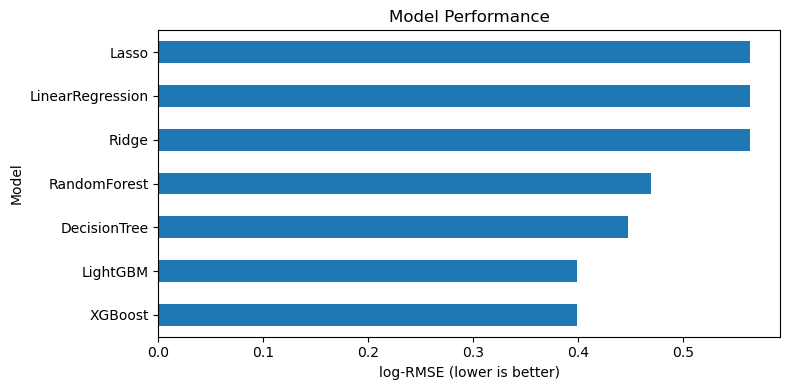

,Model,log-RMSE (mean),log-RMSE (std),RMSE (sec)
6,XGBoost,0.398900,0.003260,0.490
5,LightGBM,0.398920,0.003297,0.490
3,DecisionTree,0.447364,0.000687,0.564
4,RandomForest,0.469036,0.010992,0.598
1,Ridge,0.563941,0.000636,0.758
0,LinearRegression,0.563941,0.000636,0.758
2,Lasso,0.564209,0.000615,0.758


In [38]:
models_all = make_all_models(preprocessing)

result_all_models = get_display_models_results(
    models_all,
    X_train, y_train
)
compare_models_results(result_all_models, seconds=True)

## Top Features

In [39]:
for name, pipe in models_all.items():
  pipe.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 1166915, number of used features: 34
[LightGBM] [Info] Start training from score 6.469545


In [40]:
linreg_model = models_all['LinearRegression']
plot_lin_feature_importance(linreg_model, X_train, y_train)

AttributeError: Estimator functiontransformer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

In [ ]:
lasso_model = models_all['Lasso']
plot_lin_feature_importance(lasso_model, X_train, y_train)

In [ ]:
ridge_model = models_all['Ridge']
plot_lin_feature_importance(ridge_model, X_train, y_train)

In [ ]:
xgb_model = models_all['XGBoost']
plot_tree_feature_importance(xgb_model, X_train, y_train)

In [ ]:
lgbm_model = models_all['LightGBM']
plot_tree_feature_importance(lgbm_model, X_train, y_train)

In [ ]:
dt_model = models_all['DecisionTree']
plot_tree_feature_importance(dt_model, X_train, y_train)

In [ ]:
rf_model = models_all['RandomForest']
plot_tree_feature_importance(rf_model, X_train, y_train)